In [162]:
#coding: utf-8
%matplotlib inline

In [163]:
from __future__ import unicode_literals
import re
import os
import codecs
import json
import csv
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid
import math
import random
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter
from matplotlib import ticker

In [164]:
nlp=spacy.load('en')

In [165]:
intent_dict_AskUbuntu = {"Make Update":0, "Setup Printer":1, "Shutdown Computer":2, "Software Recommendation":3, "None":4}
intent_dict_Chatbot = {"DepartureTime":0, "FindConnection":1}
intent_dict_WebApplications = {"Download Video":0, "Change Password":1, "None":2, "Export Data":3, "Sync Accounts":4,
                  "Filter Spam":5, "Find Alternative":6, "Delete Account":7}

In [166]:
#********* Data augmentation part **************
class MeraDataset():
    """ Class to find typos based on the keyboard distribution, for QWERTY style keyboards
    
        It's the actual test set as defined in the paper that we comparing against."""

    def __init__(self, dataset_path, augmentedFile, n_splits=3, ratio=0.3, augment=False, nSamples=1):
        """ Instantiate the object.
            @param: dataset_path The directory which contains the data set.
            @param: n_splits For the stratified_split, not in use here (default 0.3).
            @param: ratio  For the stratified_split, not in use here (default 0.3).
            @param: augment If the data set should be augmented (default False)"""
        self.dataset_path = dataset_path
        self.nSamples = nSamples
        self.augment = augment
        self.augmentedFile = augmentedFile
        self.n_splits = n_splits
        self.ratio = ratio
        self.X_test, self.y_test, self.X_train, self.y_train = self.load()
        self.keyboard_cartesian = {'q': {'x': 0, 'y': 0}, 'w': {'x': 1, 'y': 0}, 'e': {'x': 2, 'y': 0},
                                   'r': {'x': 3, 'y': 0}, 't': {'x': 4, 'y': 0}, 'y': {'x': 5, 'y': 0},
                                   'u': {'x': 6, 'y': 0}, 'i': {'x': 7, 'y': 0}, 'o': {'x': 8, 'y': 0},
                                   'p': {'x': 9, 'y': 0}, 'a': {'x': 0, 'y': 1}, 'z': {'x': 0, 'y': 2},
                                   's': {'x': 1, 'y': 1}, 'x': {'x': 1, 'y': 2}, 'd': {'x': 2, 'y': 1},
                                   'c': {'x': 2, 'y': 2}, 'f': {'x': 3, 'y': 1}, 'b': {'x': 4, 'y': 2},
                                   'm': {'x': 5, 'y': 2}, 'j': {'x': 6, 'y': 1}, 'g': {'x': 4, 'y': 1},
                                   'h': {'x': 5, 'y': 1}, 'j': {'x': 6, 'y': 1}, 'k': {'x': 7, 'y': 1},
                                   'l': {'x': 8, 'y': 1}, 'v': {'x': 3, 'y': 2}, 'n': {'x': 5, 'y': 2},
                                   'ß': {'x': 10,'y': 2}, 'ü': {'x': 10,'y': 2}, 'ä': {'x': 10,'y': 0},
                                   'ö': {'x': 11,'y': 0}}
        self.nearest_to_i = self.get_nearest_to_i(self.keyboard_cartesian)
        self.splits = self.stratified_split()


    def get_nearest_to_i(self, keyboard_cartesian):
        """ Get the nearest key to the one read.
            @params: keyboard_cartesian The layout of the QWERTY keyboard for English
            
            return dictionary of eaculidean distances for the characters"""
        nearest_to_i = {}
        for i in keyboard_cartesian.keys():
            nearest_to_i[i] = []
            for j in keyboard_cartesian.keys():
                if self._euclidean_distance(i, j) > 1.2:
                    nearest_to_i[i].append(j)
        return nearest_to_i

    def _shuffle_word(self, word, cutoff=0.9):
        """ Rearange the given characters in a word simulating typos given a probability.
        
            @param: word A single word coming from a sentence
            @param: cutoff The cutoff probability to make a change (default 0.9)
            
            return The word rearranged 
            """
        word = list(word.lower())
        if random.uniform(0, 1.0) > cutoff:
            loc = np.random.randint(0, len(word))
            if word[loc].isalpha():
                word[loc] = random.choice(self.nearest_to_i[word[loc]])
        return ''.join(word)

    def _euclidean_distance(self, a, b):
        """ Calculates the euclidean between 2 points in the keyboard
            @param: a Point one 
            @param: b Point two
            
            return The euclidean distance between the two points"""
        X = (self.keyboard_cartesian[a]['x'] - self.keyboard_cartesian[b]['x']) ** 2
        Y = (self.keyboard_cartesian[a]['y'] - self.keyboard_cartesian[b]['y']) ** 2
        return math.sqrt(X + Y)

    def _augment_sentence(self, sentence, num_samples):
        """ Augment the dataset of file with a sentence shuffled
            @param: sentence The sentence from the set
            @param: num_samples The number of sentences to genererate
            
            return A set of augmented sentences"""
        sentences = []
        for _ in range(num_samples):
            sentences.append(' '.join([self._shuffle_word(item) for item in sentence.split(' ')]))
        sentences = list(set(sentences))
        # print("sentences", sentences)
        return sentences + [sentence]

    def _augment_split(self, X_train, y_train, num_samples=100):
        """ Split the augmented train dataset
            @param: X_train The full array of sentences
            @param: y_train The train labels in the train dataset
            @param: num_samples the number of new sentences to create (default 1000)
            
            return Augmented training dataset"""
        Xs, ys = [], []
        for X, y in zip(X_train, y_train):
            tmp_x = self._augment_sentence(X, num_samples)
            sample = [[Xs.append(item), ys.append(y)] for item in tmp_x]
#             print(X, y)
#             print(self.augmentedFile+str(self.nSamples)+".csv")
            
        with open(self.augmentedFile+str(self.nSamples)+".csv", 'w', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            for i in range(0, len(Xs)-1):
                fileWriter.writerow([Xs[i] + '\t' + ys[i]])
                # print(Xs[i], "\t", ys[i])
                # print(Xs[i])
            # fileWriter.writerows(Xs + ['\t'] + ys)
        return Xs, ys

    def load(self):
        """ Load the file for now only the test.csv, train.csv files hardcoded
        
            return The vector separated in test, train and the labels for each one"""
        i = 0
        
        with open(self.dataset_path) as csvfile:
            readCSV = csv.reader(csvfile, delimiter='	')
            all_rows = list(readCSV)
#             print(all_rows)
#             for i in all_rows:
#                 if i ==  28823:
#                     print(all_rows[i])
            X_test = [a[0] for a in all_rows]
            y_test = [a[1] for a in all_rows]

        with open(self.dataset_path) as csvfile:
            readCSV = csv.reader(csvfile, delimiter='\t')
            all_rows = list(readCSV)
#             print(all_rows)
            
            X_train = [a[0] for a in all_rows]
            y_train = [a[1] for a in all_rows]
        return X_test, y_test, X_train, y_train

    def process_sentence(self, x):
        """ Clean the tokens from stop words in a sentence.
            @param x Sentence to get rid of stop words.
            
            returns clean string sentence"""
        clean_tokens = []
        doc = nlp.tokenizer(x)
        for token in doc:
            if not token.is_stop:
                clean_tokens.append(token.lemma_)
        return " ".join(clean_tokens)

    def process_batch(self, X):
        """See the progress as is coming along.
        
            return list[] of clean sentences"""
        return [self.process_sentence(a) for a in tqdm(X)]

    def stratified_split(self):
        """ Split data whole into stratified test and training sets, then remove stop word from sentences
        
            return list of dictionaries with keys train,test and values the x and y for each one"""

        self.X_train, self.y_train = self._augment_split(self.X_train,
                                                         self.y_train, num_samples=self.nSamples)
#         self.X_train = self.process_batch(self.X_train)
#         self.X_test = self.process_batch(self.X_test)

        splits = [{"train": {"X": self.X_train, "y": self.y_train},
                   "test": {"X": self.X_test, "y": self.y_test}}]
#         print(splits[0]["train"]["y"])
        return splits

    def get_splits(self):
        """ Get the splitted sentences
            
            return splitted list of dictionaries"""
        return self.splits
#****************************************************

In [167]:
benchmark_dataset = 'WebApplication' #choose from 'AskUbuntu', 'Chatbot' or 'WebApplication'

In [168]:
filename_train = "datasets/KL/" + benchmark_dataset + "/train.csv"
filename_test = "datasets/KL/" + benchmark_dataset + "/test.csv"

filename_augmented = "./datasets/KL/" + benchmark_dataset + "/train_augmented"
numAug = 8


In [169]:
def read_CSV_datafile(filename):    
    X = []
    y = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            X.append(row[0])
            if benchmark_dataset == 'AskUbuntu':
                y.append(intent_dict_AskUbuntu[row[1]])
            elif benchmark_dataset == 'Chatbot':
                y.append(intent_dict_Chatbot[row[1]])
            else:
#                 print("here")
                y.append(intent_dict_WebApplications[row[1]])           
    return X,y

In [170]:

print("./datasets/KL/" + benchmark_dataset + "/train.csv")
dataset = MeraDataset("./datasets/KL/" + benchmark_dataset + "/train.csv", ratio=0.2, nSamples=numAug, augmentedFile=filename_augmented)
print("mera****************************")
splits = dataset.get_splits()
xS_train = []
yS_train = []
for elem in splits[0]["train"]["X"]:
    xS_train.append(elem)
print(xS_train[:3])
# print(splits[0]["train"]["y"])
for elem in splits[0]["train"]["y"]:
    if benchmark_dataset == 'AskUbuntu':
        yS_train.append(intent_dict_AskUbuntu[elem])
    elif benchmark_dataset == 'Chatbot':
        yS_train.append(intent_dict_Chatbot[elem])
    else:
        yS_train.append(intent_dict_WebApplications[elem])

print(yS_train)
    
# print(splits[0]["train"]["y"][1])
# print(splits[0]["train"]["y"])
# for elem in splits[0]["train"]["y"]:
#     print(intent_dict_WebApplications[elem])
# print(yS_train[:3])
# print(intent_dict_AskUbuntu[elem])


./datasets/KL/WebApplication/train.csv
mera****************************
['hoz wo h download a youtube video?', 'how do i download a yowtube video?', 'how do i download a youtube vibeo?']
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


In [171]:
X_train_raw, y_train_raw = read_CSV_datafile(filename = filename_train)
X_test_raw, y_test_raw = read_CSV_datafile(filename = filename_test)
print(y_train_raw)

X_train_raw = xS_train
y_train_raw = yS_train
print(y_train_raw)
print(X_train_raw[0:5])

[0, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
['hoz wo h download a youtube video?', 'how do i download a yowtube video?', 'how do i download a youtube vibeo?', 'how do i download i youtube video?', 'how do p download a youtube video?']


In [172]:
print("Training data samples: \n",X_train_raw[-5:-1], "\n\n")

print("Class Labels: \n", y_train_raw[0:], "\n\n")

print("Size of Training Data: {}".format(len(X_train_raw)))

Training data samples: 
 ['how to disable/delete k harvest account?', 'how to disable/delete a harvest account?', 'hou to disable/delete a harvest account?', 'how to disable/delece f harvest account?'] 


Class Labels: 
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7] 


Size of Training Data: 182


In [173]:
def tokenize(doc):
    """
    Returns a list of strings containing each token in `sentence`
    """
    #return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])",
    #                            doc) if i != '' and i != ' ' and i != '\n']
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        tokens.append(token.text)
    return tokens



In [174]:
def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

In [175]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def semhash_tokenizer(text):
    tokens = text.split(" ")
    final_tokens = []
    for unhashed_token in tokens:
        hashed_token = "#{}#".format(unhashed_token)
        final_tokens += [''.join(gram)
                         for gram in list(find_ngrams(list(hashed_token), 3))]
    return final_tokens

def semhash_corpus(corpus):
    new_corpus = []
    for sentence in corpus:
        sentence = preprocess(sentence)
        tokens = semhash_tokenizer(sentence)
        new_corpus.append(" ".join(map(str,tokens)))
    return new_corpus

X_train_raw = semhash_corpus(X_train_raw)
X_test_raw = semhash_corpus(X_test_raw)

In [176]:
X_train_raw[:5]
print(X_train_raw)

['#ho hoz oz# #wo wo# #h# #do dow own wnl nlo loa oad ad# #yo you out utu tub ube be# #vi vid ide deo eo# #?#', '#do dow own wnl nlo loa oad ad# #yo yow owt wtu tub ube be# #vi vid ide deo eo# #?#', '#do dow own wnl nlo loa oad ad# #yo you out utu tub ube be# #vi vib ibe beo eo# #?#', '#do dow own wnl nlo loa oad ad# #yo you out utu tub ube be# #vi vid ide deo eo# #?#', '#p# #do dow own wnl nlo loa oad ad# #yo you out utu tub ube be# #vi vid ide deo eo# #?#', '#dc dc# #do dow own wnl nlo loa oad ad# #yo you out utu tub ube be# #vi vid ide deo eo# #?#', '#do dow own wnl nlo loa oad ad# #yo you out utu tub ube be# #vi vid ide deo eo# #?#', '#ho how ow# #-P -PR PRO RON ON- N-# #do dow own wnl nlo loa oad ad# #yo you out utu tub ube be# #vi vid ide deo eo# #?#', '#ch cha han ang nge ge# #pa pas ass ssw swo wor ord rd# #av av# #tr tro rop ope pe# #?#', '#ch cha hak akg kge ge# #pa pas ass ssw swo wor ord rd# #tv tv# #tr tro rop ope pe# #?#', '#ch cha han ang nge ge# #mw mw# #pa pas asf sfw 

In [177]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = CountVectorizer(ngram_range=(2,4),analyzer='char')
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

In [179]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print(target_names)
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(y_test, "y_test", target_names, "target_names", "pred", pred)
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [180]:
def plot_results(results, nameClass):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    print(benchmark,nameClass, numAug)
    plt.savefig("./results_"+benchmark_dataset+nameClass+str(numAug)+".png", format="png")
    plt.show()

In [181]:
def plot_ver_bars(results, nameClass):
        """ Plot the results of the tests in a vertical fashion
            @param: results list of lists of results"""
        indices = np.arange(len(results))

        results = [[x[i] for x in results] for i in range(4)] #4 was len(results)

        #save_file("outlook.txt", results)
        clf_names, score, training_time, test_time = results
#        print(results, "func", indices, "indices", clf_names, "clf_names" )
        training_time = np.array(training_time) / np.max(training_time)
        test_time = np.array(test_time) / np.max(test_time)
        log_training_time = np.log10(training_time)
        log_test_time = np.log10(test_time)
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)

#         ax.set_yscale('log')
#         labels = np.array([0, 0.005, 0.01, 0.017, 0.22, 0.035, 0.05, 0.07, 0.1, 0.15, 0.3, 0.5, 0.7, 1.0])
        labels = training_time
        ax.set_yticks(labels)
#        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
#         ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#        ax.set_ylim([0., 2.])
##        fig1, ax1 = plt.subplots()
#         ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#        plt.yscale('log')
        plt.grid(True)
#        matplotlib.pyplot.autoscale(True, axis='both')
        plt.title("With "+ str(numAug) + " augmented data/class")
#        plt.ylim(0.6, 1.0)
#        plt.ylim(0.0,1.0)
#        labels = np.arange(0,1.05,0.05)
#        plt.xticks(labels, labels)
#        plt.yticks(labels, labels)
        plt.yticks([0.6,0.7,0.8, 0.85, 0.88, 0.91,0.94,0.97,1.0])
        plt.bar(indices, score, .1, label="accuracy", color='navy') #.4 was .2 in all
        plt.bar(indices + 0.3, training_time, .1, label="training time", color='c')
        plt.bar(indices + 0.6, test_time, .1, label="test time", color='darkorange')
#        for log time with matplotlib ^
#        plt.bar(indices + .3, log_training_time, .2, label="training time", color='c')
#        plt.bar(indices + .6, log_test_time, .2, label="test time", color='darkorange')
        plt.xlabel("Classifier "+ nameClass)
        plt.ylabel("Accuracy")
#         plt.ylabel("Log(Time)")
        #plt.yscale('log')

#         plt.xticks(())
        plt.legend(loc='lower right') #instead of 4
        plt.subplots_adjust(left=.05)
        plt.subplots_adjust(top=.90)
        plt.subplots_adjust(bottom=.15)
#        

#        plt.set_yscale('log')


        for i, c, t in zip(indices, clf_names, test_time):
#             plt.text(i, t+0.002, c, rotation=-30, clip_on=True) #was -0.05 instead of 1
            print(i,c) #to set the text of the plots i needed to check them
            # plt.savefig("./plots/"+c+".png", format="png")
        
        plt.savefig("./results_vert_"+benchmark_dataset+nameClass+str(numAug)+".png", format="png")
        plt.show()



In [182]:
def data_for_training():
    vectorizer, feature_names = get_vectorizer(X_train_raw, preprocessor=preprocess, tokenizer=tokenize)
    
    X_train = vectorizer.transform(X_train_raw).toarray()
    X_test = vectorizer.transform(X_test_raw).toarray()
            
    return X_train, y_train_raw, X_test, y_test_raw, feature_names

Evaluating Split 0
Train Size: 182
Test Size: 59
gridsearchRF
['Download Video', 'Change Password', 'None', 'Export Data', 'Sync Accounts', 'Filter Spam', 'Find Alternative', 'Delete Account']
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 40, 50, 100, 70], 'min_samples_leaf': [1, 3, 5, 11, 25], 'max_features': [0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, 

/Users/pedroalonso/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/pedroalonso/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pedroalonso/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


train time: 56.466s
test time:  0.005s
accuracy:   0.729
classification report:
[6, 7, 6, 3, 6, 7, 3, 4, 3, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2] y_test ['Download Video', 'Change Password', 'None', 'Export Data', 'Sync Accounts', 'Filter Spam', 'Find Alternative', 'Delete Account'] target_names pred [6 7 6 3 6 6 7 4 6 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 4 7 4 6 1
 1 1 1 7 6 5 7 5 5 7 5 5 6 5 5 5 5 5 5 0 7 6]
                  precision    recall  f1-score   support

  Download Video       0.00      0.00      0.00         0
 Change Password       1.00      0.67      0.80         6
            None       0.00      0.00      0.00         4
     Export Data       1.00      0.33      0.50         3
   Sync Accounts       1.00      0.50      0.67         6
     Filter Spam       1.00      0.79      0.88        14
Find Alternative       0.68      0.94      0.79        16


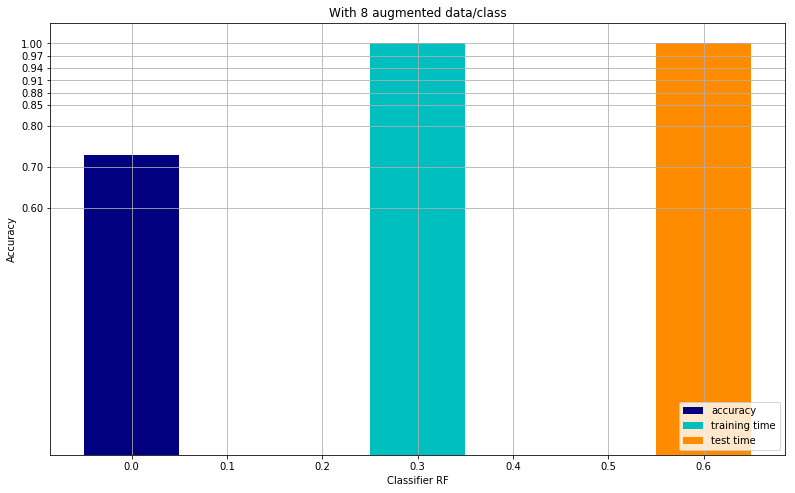

In [183]:
import matplotlib.pyplot as plt

# for numRun in range(10):
    #increment the num of DA values
for i_s, split in enumerate(range(1)):
    print("Evaluating Split {}".format(i_s))
    X_train, y_train, X_test, y_test, feature_names = data_for_training()
    if benchmark_dataset == 'Chatbot':
        target_names = ["DepartureTime","FindConnection"]
    elif benchmark_dataset == 'WebApplication':
        target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
    else:
        target_names = ["Make Update", "Setup Printer", "Shutdown Computer", "Software Recommendation", "None"]
        
    print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
    results = []
    
    parameters_RF={ "n_estimators" : [10,20,40,50,100,70],
           "min_samples_leaf" : [1,3,5,11,25],
                  "max_features" : [0.5,1]}
    
    for clf, name in [ 
        (GridSearchCV(RandomForestClassifier(n_estimators=10),parameters_RF, cv=5),"gridsearchRF")
        ]:
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, X_train, y_train, X_test, y_test, target_names, feature_names=feature_names))
        
#         plot_results(results, nameClass='RF')
        plot_ver_bars(results,nameClass='RF')


In [ ]:
import matplotlib.pyplot as plt
for i_s, split in enumerate(range(1)):
    print("Evaluating Split {}".format(i_s))
    X_train, y_train, X_test, y_test, feature_names = data_for_training()
    #target_names = ["DepartureTime","FindConnection"]
#     target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
#                   "Filter Spam", "Find Alternative", "Delete Account"]
    if benchmark_dataset == 'Chatbot':
        target_names = ["DepartureTime","FindConnection"]
    elif benchmark_dataset == 'WebApplication':
        target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
    else:
        target_names = ["Make Update", "Setup Printer", "Shutdown Computer", "Software Recommendation", "None"]
    
    print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
    results = []
    parameters_mlp={'hidden_layer_sizes':[(100,50), (300, 100),(300,200,100)]}
    for clf, name in [
        (GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=8),"gridsearchmlp")
        ]:
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))
        
#         plot_results(results, nameClass="MLP")
        plot_ver_bars(results, nameClass='MLP')
        

Evaluating Split 0
Train Size: 182
Test Size: 59
gridsearchmlp
['Download Video', 'Change Password', 'None', 'Export Data', 'Sync Accounts', 'Filter Spam', 'Find Alternative', 'Delete Account']
________________________________________________________________________________
Training: 
GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [(100, 50), (300, 100), (300, 200, 100)]},
       pre_dispatch='2*n_jobs', refit=True, return_train